In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from itertools import combinations
from pathlib import Path

In [2]:
sns.set(style="whitegrid")
base_dir = Path().resolve()
file_name = "Descriptors.xlsx"
file_path = base_dir / file_name

if not file_path.exists():
    raise FileNotFoundError(
        f"Plik {file_path} nie został znaleziony. "
        f"Upewnij się, że znajduje się w katalogu: {base_dir}"
    )

data = pd.read_excel(file_path)
print(f"Wczytano plik: {file_path}")
print(f"Rozmiar danych: {data.shape[0]} wierszy × {data.shape[1]} kolumn")
display(data.head())

Wczytano plik: E:\korepetycje_Jakub_Bozek\Descriptors.xlsx
Rozmiar danych: 20 wierszy × 211 kolumn


,Name,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Mocap,12.034676,12.034676,0.546336,-2.419051,0.588579,11.923077,242.346,223.194,242.056408,...,0,0,0,0,0,0,0,0,0,0
1,Frumin,5.507495,5.507495,0.644046,-2.022856,0.469026,11.928571,274.413,255.261,274.028479,...,1,0,0,0,0,0,0,0,2,0
2,Rampart,5.469779,5.469779,0.639950,-2.019869,0.374797,11.923077,260.386,243.250,260.012829,...,1,0,0,0,0,0,0,0,1,0
3,Thiacloprid,8.539632,8.539632,0.491169,0.491169,0.597687,17.750000,252.730,243.658,252.023645,...,1,0,0,0,0,0,0,0,0,0
4,DDT,6.112705,6.112705,0.382377,-1.456687,0.540334,11.894737,354.491,345.419,351.914689,...,0,0,0,0,0,0,0,0,0,0


In [3]:
label_col_candidates = ["target", "class", "label", "y"]
label_col = None
for col in label_col_candidates:
    if col in data.columns:
        label_col = col
        break

if label_col is None:
    non_numeric_cols = data.select_dtypes(exclude=[np.number]).columns.tolist()
    if len(non_numeric_cols) == 1:
        label_col = non_numeric_cols[0]

In [4]:
X = data.select_dtypes(include=[np.number]).copy()
if label_col is not None and label_col in X.columns:
    X = X.drop(columns=[label_col])

In [5]:

if label_col is not None:
    df_tmp = pd.concat([X, data[label_col]], axis=1)
    before = df_tmp.shape[0]
    df_tmp = df_tmp.dropna()
    dropped = before - df_tmp.shape[0]
    if dropped > 0:
        print(f"Usunięto {dropped} wierszy z brakami (synchronizacja X i etykiet).")
    X = df_tmp[X.columns]
    y = df_tmp[label_col]
else:
    before = X.shape[0]
    X = X.dropna()
    dropped = before - X.shape[0]
    if dropped > 0:
        print(f"Usunięto {dropped} wierszy z brakami.")
    y = None
    print("X shape:", X.shape)
if y is not None:
    print(f"y shape: {y.shape} | kolumna etykiet: {label_col}")



y shape: (20,) | kolumna etykiet: Name


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [7]:
evr = pca.explained_variance_ratio_
print("Explained variance ratio (PC1, PC2):", evr)
pc1_var = f"{evr[0]*100:.1f}%"
pc2_var = f"{evr[1]*100:.1f}%"

Explained variance ratio (PC1, PC2): [0.2742958  0.21447649]


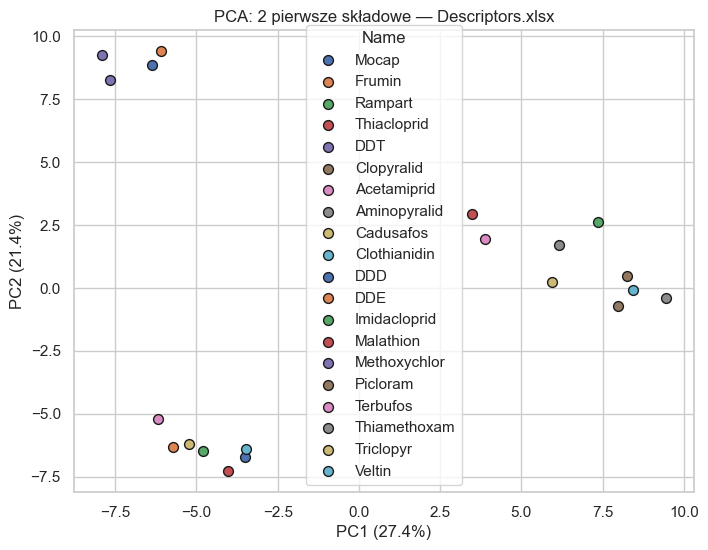

In [8]:
plt.figure(figsize=(8, 6))
if y is not None:
    # Jeżeli etykiety kategoryczne (tekst), zamień na kody; jeżeli numeryczne — użyj bezpośrednio
    if y.dtype.kind in {"O", "U", "S"}:
        y_codes, uniques = pd.factorize(y)
        for code, name in enumerate(uniques):
            mask = (y_codes == code)
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=str(name), edgecolor='k', s=50)
        plt.legend(title=str(label_col))
    else:
        sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.values, edgecolor='k', s=50)
        plt.colorbar(sc, label=str(label_col))
else:
    plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='k', s=50)

plt.xlabel(f'PC1 ({pc1_var})')
plt.ylabel(f'PC2 ({pc2_var})')
plt.title('PCA: 2 pierwsze składowe — Descriptors.xlsx')
plt.grid(True)
plt.show()


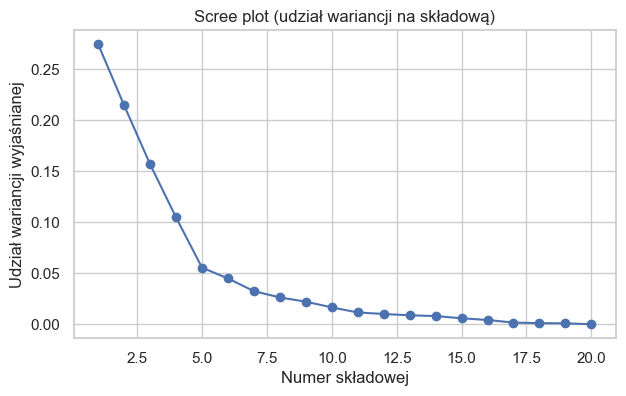

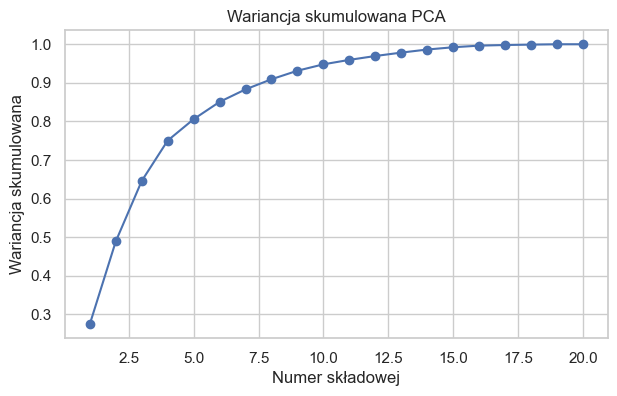

In [9]:
pca_full = PCA(n_components=None)
pca_full.fit(X_scaled)
evr_full = pca_full.explained_variance_ratio_

plt.figure(figsize=(7, 4))
plt.plot(range(1, len(evr_full) + 1), evr_full, marker='o')
plt.xlabel('Numer składowej')
plt.ylabel('Udział wariancji wyjaśnianej')
plt.title('Scree plot (udział wariancji na składową)')
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(range(1, len(evr_full) + 1), np.cumsum(evr_full), marker='o')
plt.xlabel('Numer składowej')
plt.ylabel('Wariancja skumulowana')
plt.title('Wariancja skumulowana PCA')
plt.grid(True)
plt.show()


In [10]:
loadings = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=['PC1', 'PC2']
).T.sort_values('PC1', key=lambda s: s.abs(), ascending=False)

print("Loadings (wkład cech w PC1/PC2) — top 10 wg |PC1|:")
display(loadings.head(10))

Loadings (wkład cech w PC1/PC2) — top 10 wg |PC1|:


,PC1,PC2
fr_Ar_N,0.151828,0.028024
NumAromaticHeterocycles,0.151828,0.028024
PEOE_VSA7,-0.143464,0.034507
Chi0v,-0.141985,0.001485
PEOE_VSA3,0.141510,0.023498
VSA_EState3,0.139465,0.036641
MolMR,-0.138940,0.048016
TPSA,0.137886,-0.029074
MolLogP,-0.135344,0.052344
FpDensityMorgan1,0.135242,-0.054279


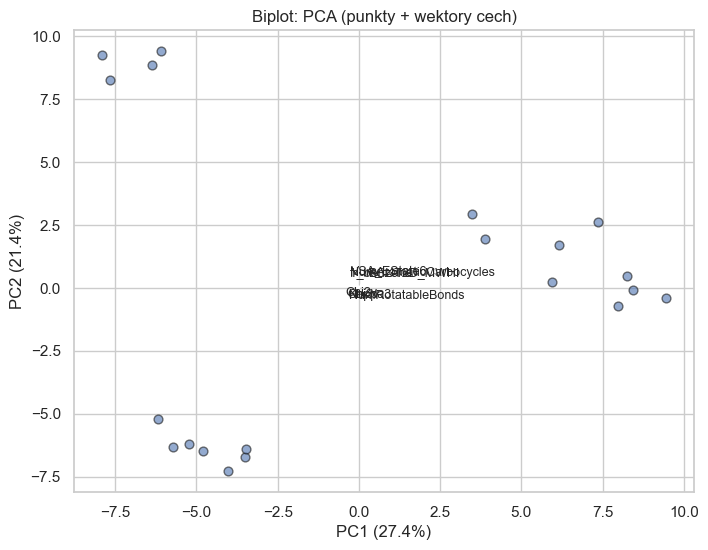

In [ ]:
scores = X_pca
components = pca.components_
feature_names = np.array(X.columns)
top_n = min(8, len(feature_names))
order = np.argsort(np.abs(components[0]) + np.abs(components[1]))[::-1][:top_n]
feat_idx = order
feat_names = feature_names[feat_idx]

plt.figure(figsize=(8, 6))
plt.scatter(scores[:, 0], scores[:, 1], alpha=0.6, edgecolor='k', s=40)
scale_x = 1.0
scale_y = 1.0

for i, feat in enumerate(feat_idx):
    plt.arrow(0, 0,
              components[0, feat]*scale_x*3,
              components[1, feat]*scale_y*3,
              head_width=0.05, length_includes_head=True)
    plt.text(components[0, feat]*scale_x*3*1.1,
             components[1, feat]*scale_y*3*1.1,
             feature_names[feat], fontsize=9)

plt.xlabel(f'PC1 ({pc1_var})')
plt.ylabel(f'PC2 ({pc2_var})')
plt.title('Biplot: PCA (punkty + wektory cech)')
plt.grid(True)
plt.show()

In [12]:
if y is not None and np.issubdtype(y.dtype, np.number):
    lr = LinearRegression()
    lr.fit(scores, y.values)
    r2 = lr.score(scores, y.values)
    print(f"LinearRegression na (PC1, PC2) → R^2 = {r2:.4f}")
    y_pred = lr.predict(scores)
    residuals = y.values - y_pred
    plt.figure(figsize=(7, 4))
    sns.histplot(residuals, kde=True)
    plt.title("Rozkład reszt (y - y_pred)")
    plt.xlabel("Reszty")
    plt.show()

    # test Shapiro-Wilka dla normalności reszt
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"Shapiro-Wilk: stat={shapiro_stat:.4f}, p-value={shapiro_p:.4g}")

In [13]:
pair_corr = []
for a, b in combinations(X.columns, 2):
    r = np.corrcoef(X[a], X[b])[0, 1]
    pair_corr.append((a, b, r))

pair_corr_df = pd.DataFrame(pair_corr, columns=["var1", "var2", "pearson_r"])
print("Przykładowe korelacje par cech (pierwsze 5):")
display(pair_corr_df.head())

C:\Users\olaba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\olaba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Przykładowe korelacje par cech (pierwsze 5):


,var1,var2,pearson_r
0,MaxAbsEStateIndex,MaxEStateIndex,1.000000
1,MaxAbsEStateIndex,MinAbsEStateIndex,-0.457728
2,MaxAbsEStateIndex,MinEStateIndex,-0.127171
3,MaxAbsEStateIndex,qed,0.220945
4,MaxAbsEStateIndex,SPS,0.220910
